# Color Segmentation

La segmentación, si bien bajo muchos aspectos consiste en una operación bastante simple, es un proceso bastante útil a la hora de desarrollar algoritmos de detección de objetos o tracking. En términos simples, segmentar una imagen consiste en seccionar o aislar zonas de una imagen en función de algún atributo, como por ejemplo, intensidad o color.

En este tutorial aprenderá los primeros pasos en cuanto a procesamiento de imágenes, desde cargar las imágenes como arreglos numéricos, hasta manipular sus valores mediante filtros y segmentadores.

<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_01/bin/shrek_ret.png" height="200">

## OpenCV

La Open Surce Computer Vision es una librería especializada en herramientas de visión computacional y en todo lo que respecta a visión artificial en general. De este modo provee de funcionalidades de todo tipo de complejidad, desde operaciones básicas de procesamiento de imágenes, hasta algoritmos de reconocimiento de objetos.

Por supuesto, esta librería cuenta con su documentación correspondiente. En esta puede encontrar descripciones más detalladas de sus funcionalidades, así como también ejemplos, tutoriales y otros.

https://docs.opencv.org/master/

<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_01/bin/opencv_logo.png" height="200">

## Load an Image
La imagen `shrek.jpg` con que trabajaremos en este workshop se encuentra en el repositorio del curso, de este modo lo primero que haremos será clonar este github.

In [6]:
!git clone https://github.com/cherrerab/roboticafcfm.git
%cd /content/roboticafcfm

Cloning into 'roboticafcfm'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.
/content/roboticafcfm


Para cargar imágenes mediante OpenCV lo más común es utilizar la función `cv2.imread`, la cual recibe únicamente la dirección del archivo. En este caso, la imagen se encuentra en `\content\roboticafcfm\auxiliar_01\shrek.jpg`.

In [10]:
import numpy as np
import cv2

# dirección de la imagen
img_path = 'auxiliar_01//shrek.jpg'

# load image
img = cv2.imread(img_path)

# print type de img
print('type(img):', type(img))

print('\nimg.shape:', img.shape)
print('\nimg.dtype:', img.dtype)


type(img): <class 'numpy.ndarray'>

img.shape: (675, 1200, 3)

img.dtype: uint8


Podemos notar que la variable `img` generada al cargar la imagen consiste en un `np.array` de tres dimensiones de valores `uint8`, o bien, valores enteros positivos de 8-bits. El tamaño `(675, 1200, 3)` indica que la imagen tiene un `height` de 675 px, un `width` de 1200 px, y tres `channels` BGR.

Debemos poner atención a que los canales que entrega `cv2.imread` están en BGR y no en RGB, como normalmente esperaríamos. Para observar esta diferencia, podemos visualizar la imagen mediante `matplotlib` y la función `plt.imshow`.

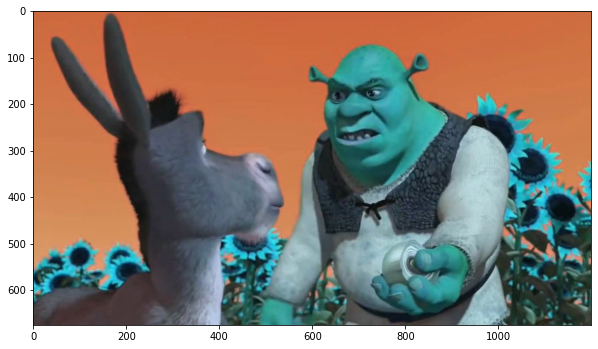

In [11]:
import matplotlib.pyplot as plt

# plotear imagen en BGR
plt.figure( figsize=(10,10) )
plt.imshow( img )

Para corregir esto, basta usar la funcionalidad `cv2.cvtColor` que permite transformar el `colorspace` de una imagen directamente a otro. Dado que en este caso queremos pasar de BGR a RGB, utilizaremos el código `cv2.COLOR_BGR2RGB`.

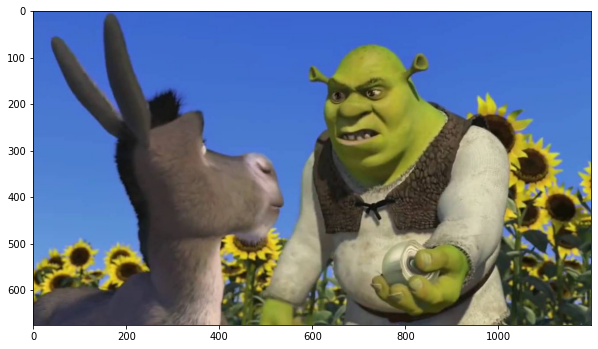

In [12]:
import matplotlib.pyplot as plt

# transformar imagen a RGB
img_rgb = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )

# plotear imagen en RGB
plt.figure( figsize=(10,10) )
plt.imshow( img_rgb )

## HSV Analysis
La segmentación por color finalmente consiste en binzarizar nuestra imagen considerando únicamente un rango en base a la rueda de color. De este modo, aquellos pixeles cuyos valores se encuentren dentro del rango pasarán a `1`, mientras que aquellos que no, a `0`.

Pero, cómo determinamos este rango?

La estrategia más directa es hacerlo al ojímetro y ajustar mediante prueba y error. Pero el método más confiable, o sistemático, es utilizar histrogramas. Siguiendo este método, primero transformaremos la imagen a HSV utilizando `cv2.cvtColor`, y luego generaremos su histograma de valores `HUE` mediante `plt.hist`.

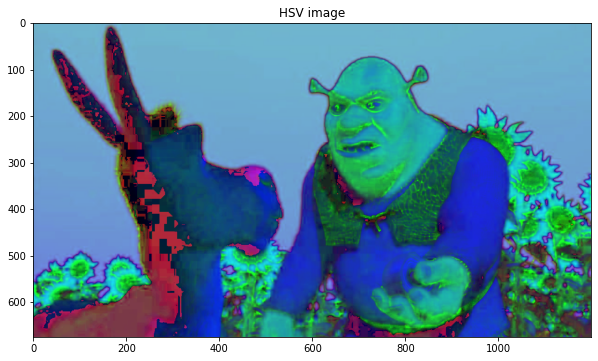

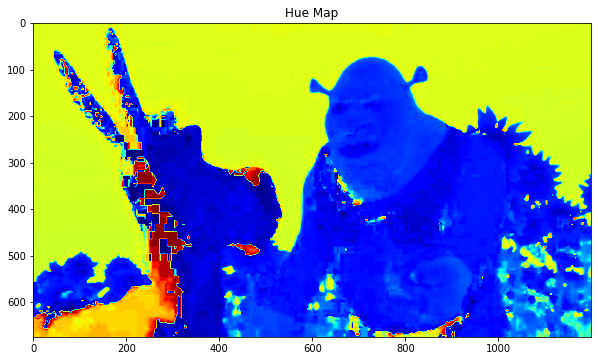

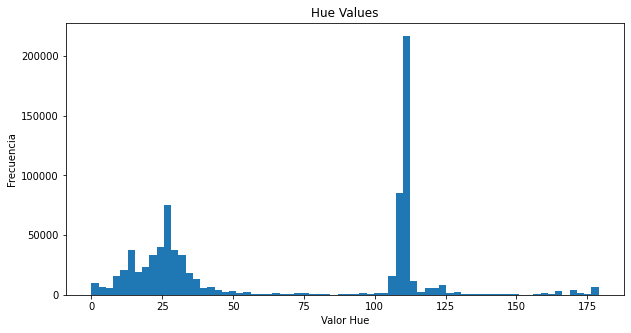

In [29]:
# transformar imagen a HSV
img_hsv = cv2.cvtColor( img, cv2.COLOR_BGR2HSV )

# plotear imagen en HSV
plt.figure( figsize=(10,10) )
plt.title( 'HSV image' )
plt.imshow( img_hsv )

# obtener array de valores HUE
img_HUE = img_hsv[:, :, 0]

# plotear array de valores HUE
plt.figure( figsize=(10,10) )
plt.title( 'Hue Map' )
plt.imshow( img_HUE, cmap='jet')

# plotear su histograma
img_HUE = img_HUE.flatten()

plt.figure( figsize=(10,5) )
plt.title( 'Hue Values' )
plt.xlabel( 'Valor Hue' ); plt.ylabel( 'Frecuencia' )

_ = plt.hist( img_HUE, 70 )

Podemos notar del histograma que existen dos zonas que concentran los valores `HUE` dentro de la imagen. La más obvia quizás sea la que se encuentra centrada en `110` que, siguiendo la rueda de calor, se corresponde con el color azúl y por tanto, con los pixeles que conforman el cielo en la imagen.

Ahora, la zona que más nos interesa es la que se encuentra en torno a `28`. De acuerdo a la rueda de color, este rango se corresponde con amarillos verdosos, lo cual tiene sentido, pues Shrek en realidad no es de un verde muy vibrante.

Teniendo estos valores en cuenta, ahora podemos definir un rango para realizar la segmentación. Para esto, utilizaremos la función `cv2.inRange` la cual binarizará la imagen a partir de los límites que le entreguemos.

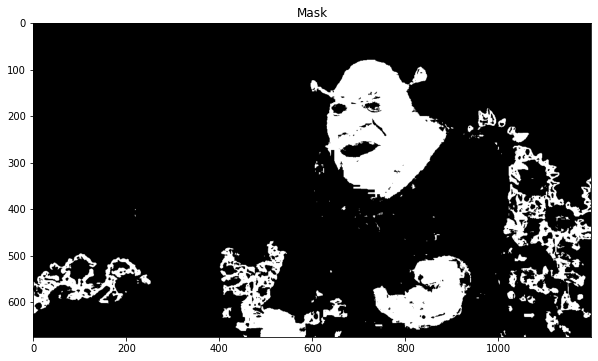

In [50]:
# definir límite inferior
lower_hsv = np.array( [24, 90, 20] )

# definir límite superior
upper_hsv = np.array( [35, 220, 255] )

# segmentar mediante cv2.inRange
mask = cv2.inRange( img_hsv, lower_hsv, upper_hsv)

# visualizar resultado
plt.figure( figsize=(10, 10) )
plt.title( 'Mask' )

plt.imshow(mask, cmap='gray')

Perturbador.

Si bien hemos logrado un buen resultado, se podría decir que este no es muy limpio. Este `mask` tiene bastante ruido y se ha filtrado un poco de los girasoles del fondo. Podemos controlar esto si aplicamos previamente un filtro gaussiano sobre la imagen, mediante `cv2.GaussianBlur`.

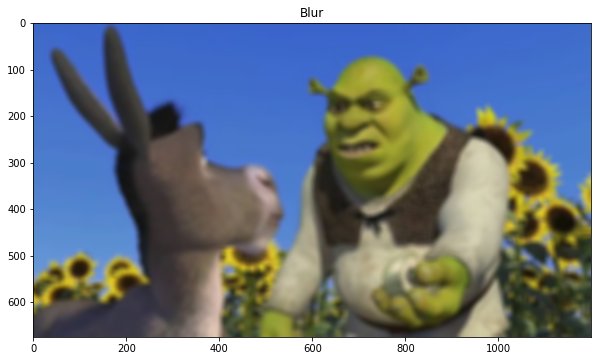

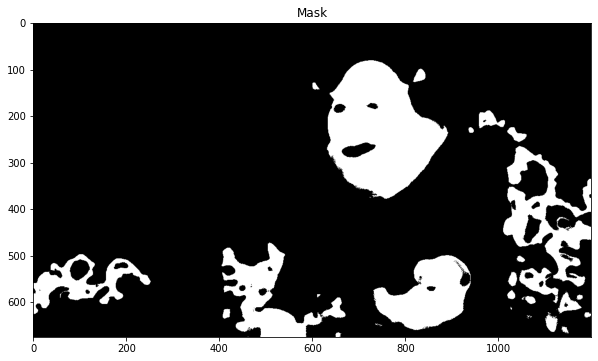

In [51]:
# aplicar filtro gaussiano sobre la imagen RGB
rgb_blur = cv2.GaussianBlur(img_rgb, (15, 15), 8)

# visualizar imagen suavizada
plt.figure( figsize=(10, 10) )
plt.title( 'Blur' )

plt.imshow(rgb_blur)

# transformar a HSV
hsv_blur = cv2.cvtColor( rgb_blur, cv2.COLOR_RGB2HSV )

# segmentar mediante cv2.inRange
mask = cv2.inRange( hsv_blur, lower_hsv, upper_hsv)

# visualizar resultado
plt.figure( figsize=(10, 10) )
plt.title( 'Mask' )

plt.imshow(mask, cmap='gray')



In [5]:
!rm -r /content/roboticafcfm

rm: cannot remove '/content/roboticafcfm': No such file or directory
